In [1]:
from typing import Dict, NamedTuple, Optional
import torch
import numpy as np
from numpy.random import default_rng
from sklearn import linear_model
import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\Benedikt\Anaconda3\envs\standard\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class PVTrainDataSet(NamedTuple):
    treatment: np.ndarray
    treatment_proxy: np.ndarray
    outcome_proxy: np.ndarray
    outcome: np.ndarray
        
class PVTestDataSet(NamedTuple):
    treatment: np.ndarray
    structural: Optional[np.ndarray]

In [3]:
def psi(t: np.ndarray) -> np.ndarray:
    return 2 * ((t - 5) ** 4 / 600 + np.exp(-4 * (t - 5) ** 2) + t / 10 - 2)

def generatate_demand_core(n_sample: int, rng, Z_noise: float = 1, W_noise: float = 1):
    demand = rng.uniform(0, 10, n_sample)
    cost1 = 2 * np.sin(demand * np.pi * 2 / 10) + rng.normal(0, Z_noise, n_sample)
    cost2 = 2 * np.cos(demand * np.pi * 2 / 10) + rng.normal(0, Z_noise, n_sample)
    price = 35 + (cost1 + 3) * psi(demand) + cost2 + rng.normal(0, 1.0, n_sample)
    views = 7 * psi(demand) + 45 + rng.normal(0, W_noise, n_sample)
    outcome = cal_outcome(price, views, demand)
    return demand, cost1, cost2, price, views, outcome

def generate_train_demand_pv(n_sample: int, Z_noise: float = 1, W_noise: float = 1,
                             seed=42, **kwargs):
    rng = default_rng(seed=seed)
    demand, cost1, cost2, price, views, outcome = generatate_demand_core(n_sample, rng, Z_noise, W_noise)
    outcome = (outcome + rng.normal(0, 1.0, n_sample)).astype(float)
    return PVTrainDataSet(treatment=price[:, np.newaxis],
                          treatment_proxy=np.c_[cost1, cost2],
                          outcome_proxy=views[:, np.newaxis],
                          outcome=outcome[:, np.newaxis]
                         )

def cal_outcome(price, views, demand):
    return np.clip(np.exp((views - price) / 10.0), None, 5.0) * price - 5 * psi(demand)


def cal_structural(p: float, W_noise: float = 1):
    rng = default_rng(seed=42)
    # U
    demand = rng.uniform(0, 10.0, 10000)
    # W
    views = 7 * psi(demand) + 45 + rng.normal(0, W_noise, 10000)
    # Y
    outcome = cal_outcome(p, views, demand)
    # for each A=p (price) average over W & U to get Y_A = Y_p
    return np.mean(outcome)


def generate_test_demand_pv(W_noise: float = 1, **kwargs):
    price = np.linspace(10, 30, 10)
    struc = np.array([cal_structural(p, W_noise) for p in price])
    return PVTestDataSet(structural=struc[:, np.newaxis],
                         treatment=price[:, np.newaxis])

In [12]:
n_sample = 1000
random_seed = 100

In [13]:
first_stage_train_data_org = generate_train_demand_pv(n_sample=n_sample, seed=random_seed)
second_stage_train_data_org = generate_train_demand_pv(n_sample=n_sample, seed=random_seed + 2)
val_data_org = generate_train_demand_pv(n_sample=n_sample, seed=random_seed + 1)
test_data_org = generate_test_demand_pv()

In [14]:
# train 2SLS model (from Miao et al.)
first_stage_model = linear_model.LinearRegression()  # W ~ A + Z
second_stage_model = linear_model.LinearRegression()  # Y ~ A + \hat{W}

In [15]:
# W
first_stage_W = first_stage_train_data_org.outcome_proxy.reshape(-1, 1)
# A, Z1, Z2
first_stage_features = np.concatenate((first_stage_train_data_org.treatment, first_stage_train_data_org.treatment_proxy), axis=1)
# fit first model: W ~ A + Z1 + Z2
first_stage_model.fit(first_stage_features, first_stage_W)
# \hat{W} predicted
W_hat = first_stage_model.predict(
    np.concatenate((second_stage_train_data_org.treatment, second_stage_train_data_org.treatment_proxy), axis=1))
# fit second model: Y ~ A + \hat{W}
second_stage_model.fit(np.concatenate((second_stage_train_data_org.treatment, W_hat), axis=1),
                       second_stage_train_data_org.outcome.reshape(-1, 1))

LinearRegression()

In [16]:
# dimension stuff for creating eval set
intervention_array_len = test_data_org.treatment.shape[0]
num_val_samples = val_data_org.treatment.shape[0]
a = test_data_org.treatment
temp_A = np.broadcast_to(a,(a.shape[0], num_val_samples))
w = val_data_org.outcome_proxy
temp_W = np.broadcast_to(w,(w.shape[0], intervention_array_len))
AW_test = np.stack((temp_A, temp_W.T), axis=-1) # dim (a_steps, n_sample, dim(A)+dim(W))

In [17]:
# we train the model on (A, \hat{W}), but evaluate it on (A, W) on test/outcome set?
# for each a, we predict (a, w_i)_i^{n_sample} and take the average
pred = [np.mean(second_stage_model.predict(AW_test[i, :, :])) for i in range(AW_test.shape[0])]
oos_loss: float = np.mean((pred - test_data_org.structural.squeeze()) ** 2)
oos_loss
# same (very close) result to paper, I have not averaged over 20 seeds

90.17254213058216

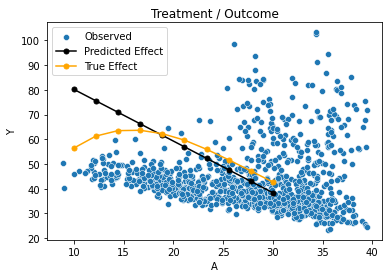

In [20]:
A = np.squeeze(first_stage_train_data_org.treatment)
Y = np.squeeze(first_stage_train_data_org.outcome)
y_pred = np.array(pred)
a_treat = np.squeeze(a)
y_true = test_data_org.structural.squeeze()
sns.scatterplot(x=A, y=Y, label='Observed')
plt.plot(a_treat, y_pred, color='black', marker='o', label="Predicted Effect", markersize=5)
plt.plot(a_treat, y_true, color='orange', marker='o', label="True Effect", markersize=5)
plt.title('Treatment / Outcome')
plt.xlabel('A')
plt.ylabel('Y')
plt.legend()
plt.show()

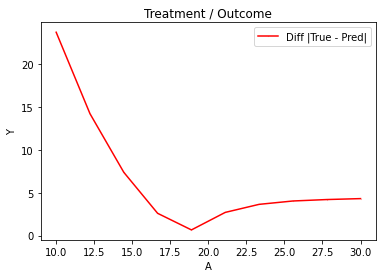

In [21]:
plt.plot(a_treat, np.abs(y_true - y_pred), color='red', marker='o', label="Diff |True - Pred|", markersize=0.1)
plt.title('Treatment / Outcome')
plt.xlabel('A')
plt.ylabel('Y')
plt.legend()
plt.show()